Directions: \\
1. Download the dataset from \\
https://www.kaggle.com/datasets/apollo2506/facial-recognition-dataset/code \\
by pressing the download \\
2. From the downloaded zip file, unzip the Training and Testing folders to your local drive  \\
3. Create a folder named 'facial-recognition-dataset' on your Google drive \\
4. Upload the Training and Testing folders to the 'facial-recognition-dataset' folder on your Google drive (this step could take some time to upload all the files. The process could be expedited by uploading the zip file and unzipping
on your Google drive. But this requires an extension that you may not currently have.) \\
5. In Google colab menu, choose Edit --> Notebook Setting --> T4 GPU
6. Run the code below to mount your Google drive as a local drive within Google colab \\
Initial code programming reference for VGG19 architecture \\
https://www.kaggle.com/code/rajsahilcoder/facial-recognition-v3\\


In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/gdrive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT)           # we mount the google drive at /content/gdrive

gpath = '/content/gdrive/MyDrive/'

/content/gdrive
Mounted at /content/gdrive


In [ ]:
#choose the appropriate folder
%cd /content/gdrive/MyDrive/facial-recognition-dataset
TRAIN_DIR = ('./Training/Training/')
TEST_DIR = ('./Testing/Testing/')

/content/gdrive/MyDrive/facial-recognition-dataset


In [ ]:
ls

archive.zip  facial_train_test_sets.npz  Testing/  Training/


We will begin using this code from the Kaggle webste: \\
https://www.kaggle.com/code/rajsahilcoder/facial-recognition-v3  

In [ ]:
#run the necessary imports
import numpy as np
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
def load_data(dir_path, IMG_SIZE):

    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

# Load the training set
Run this code only once to load and process the training set \\

In [ ]:
IMG_SIZE= (48, 48)
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [03:57<00:00, 39.58s/it]

9809 images loaded from ./Training/Training/ directory.


In [ ]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

# Load the test set
Run this code only once to load and process the test set \\

In [ ]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [02:32<00:00, 25.42s/it]

7067 images loaded from ./Testing/Testing/ directory.


# Save the Data
Run this code only once to ***save*** the processed training and test sets \\
Then you can load anytime you need the these sets \\

In [ ]:
#run this once
np.savez('facial_train_test_sets.npz', X_train, y_train, train_labels, X_test, y_test, test_labels)

# Load the processed training and test sets
Run these commands anytime to quickly load the data sets \\
to be fed to the deep learning networks \\

In [ ]:
loaded_sets = np.load('facial_train_test_sets.npz', allow_pickle = True)
X_train = loaded_sets['arr_0']
y_train = loaded_sets['arr_1']
train_labels = loaded_sets['arr_2'][()]
X_test = loaded_sets['arr_3']
y_test = loaded_sets['arr_4']
test_labels = loaded_sets['arr_5'][()]


Plot some samples

In [ ]:
def plot_samples(X, y, labels_dict, n=50):

    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

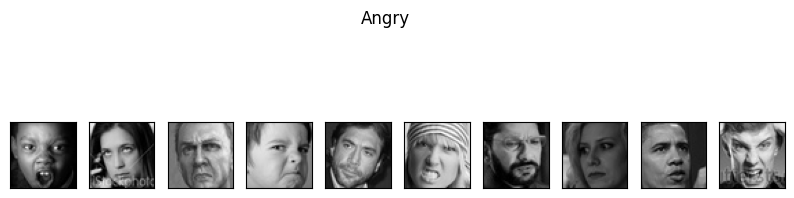

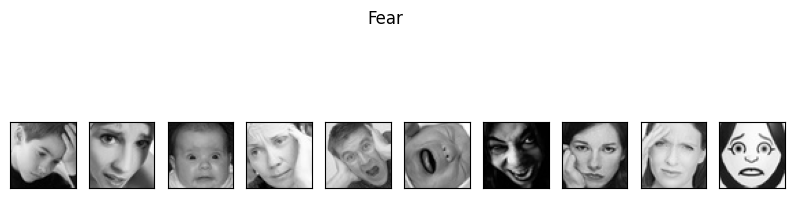

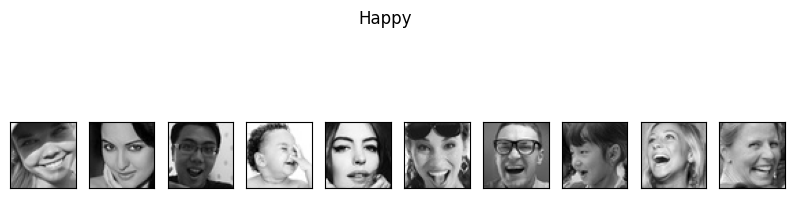

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

In [ ]:
plot_samples(X_train, y_train, train_labels, 10)

Encode categorical data

In [ ]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_train.shape

(9809, 6)

In [ ]:
Y_test = to_categorical(y_test, num_classes=6)
Y_test.shape

(7067, 6)

In [ ]:
NUM_CLASSES = 6

Make sure T4 GPU is running

In [ ]:
# Check GPU availability
print("GPU Available:", tf.test.is_gpu_available())

# Check TPU availability
tpu_available = False
devices = tf.config.list_logical_devices()
for device in devices:
    if device.device_type == 'TPU':
        tpu_available = True
        break

print("TPU Available:", tpu_available)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True
TPU Available: False


Choose keras VGG19 model and connect output to a FFNN

In [ ]:
#build VGG19 model
from keras.applications.vgg19 import VGG19

base_model = VGG19(
        weights=None,
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )

base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
#coonect output to FFNN
NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(NUM_CLASSES, activation="softmax"))


In [ ]:
def deep_model(model, X_train, Y_train, epochs, batch_size):

    model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

#     es = EarlyStopping(monitor='val_loss',
#                            restore_best_weights=True,
#                            mode='min'
#                           min_delta=1.5)
    history = model.fit(X_train
                       , Y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , verbose=1)
    return history

Train the model

In [ ]:
#chnage epcohs back to 500 when ready to run the whole test
#epochs = 500
epochs = 10
batch_size = 128

history = deep_model(model, X_train, Y_train, epochs, batch_size)

Epoch 1/10
77/77 [==============================] - 25s 162ms/step - loss: 0.4525 - accuracy: 0.4045
Epoch 2/10
77/77 [==============================] - 9s 118ms/step - loss: 0.3118 - accuracy: 0.4189
Epoch 3/10
77/77 [==============================] - 9s 118ms/step - loss: 0.3079 - accuracy: 0.4213
Epoch 4/10
77/77 [==============================] - 9s 120ms/step - loss: 0.3067 - accuracy: 0.4131
Epoch 5/10
77/77 [==============================] - 9s 120ms/step - loss: 0.3061 - accuracy: 0.4174
Epoch 6/10
77/77 [==============================] - 9s 122ms/step - loss: 0.3056 - accuracy: 0.4107
Epoch 7/10
77/77 [==============================] - 9s 123ms/step - loss: 0.3052 - accuracy: 0.4104
Epoch 8/10
77/77 [==============================] - 10s 124ms/step - loss: 0.3052 - accuracy: 0.4156
Epoch 9/10
77/77 [==============================] - 10s 126ms/step - loss: 0.3048 - accuracy: 0.4191
Epoch 10/10
77/77 [==============================] - 10s 127ms/step - loss: 0.3050 - accuracy: 0.

Plot confusion matrix and analyze test results

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

221/221 [==============================] - 6s 19ms/step
Test Accuracy = 0.14


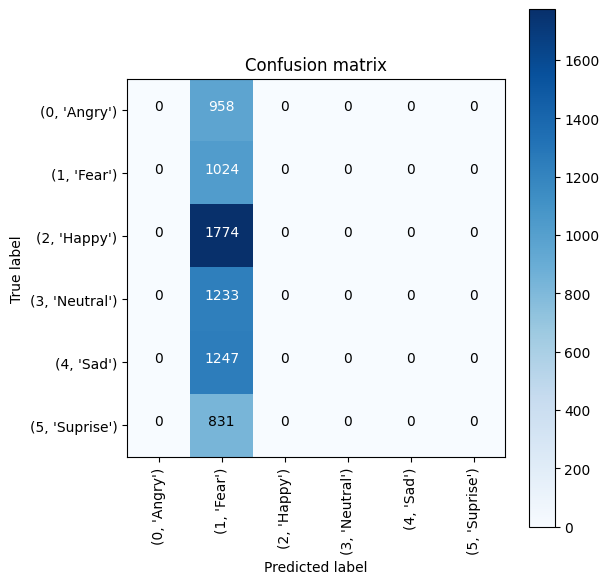

In [ ]:
# Validate on test set

predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]


accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred)
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen_test = ImageDataGenerator(rescale = 1./255)
pred_generator = datagen_test.flow_from_directory(TEST_DIR,
                                                 target_size = (48,48),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=False)

Found 7067 images belonging to 6 classes.


In [ ]:
new_predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in new_predictions]
y_pred = [test_labels[k] for k in y_pred]



221/221 [==============================] - 3s 14ms/step


In [ ]:
filenames = pred_generator.filenames
actual_class = [test_labels[h] for h in pred_generator.classes]

In [ ]:


import pandas as pd

pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":y_pred,
                           "Actual Values":actual_class})

pred_result.head()


,Filename,Predictions,Actual Values
0,Angry/Angry-1.jpg,Fear,Angry
1,Angry/Angry-10.jpg,Fear,Angry
2,Angry/Angry-100.jpg,Fear,Angry
3,Angry/Angry-101.jpg,Fear,Angry
4,Angry/Angry-102.jpg,Fear,Angry


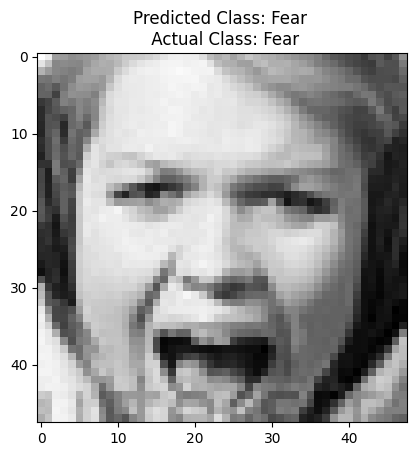

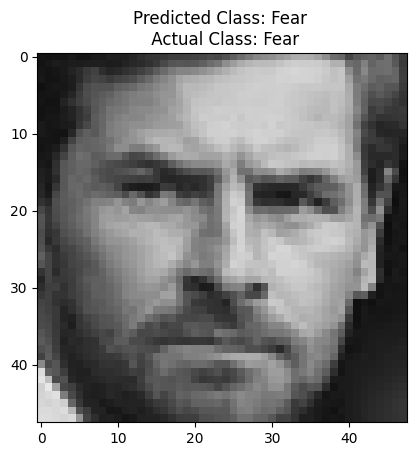

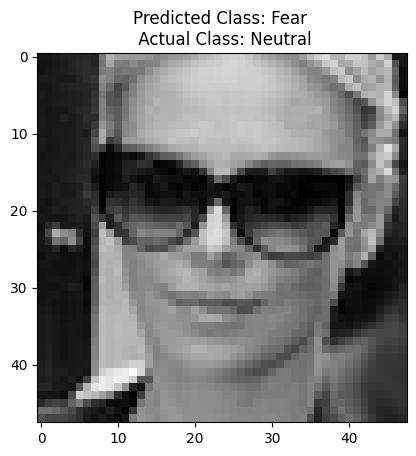

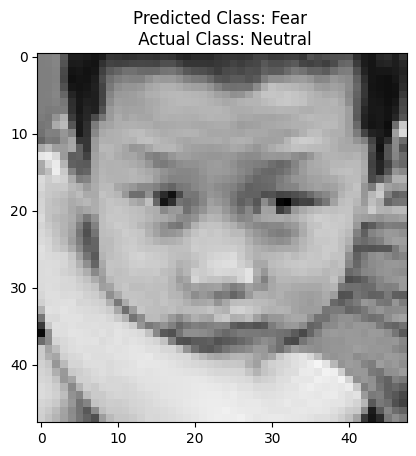

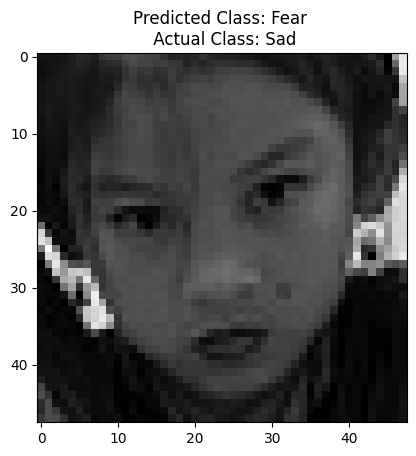

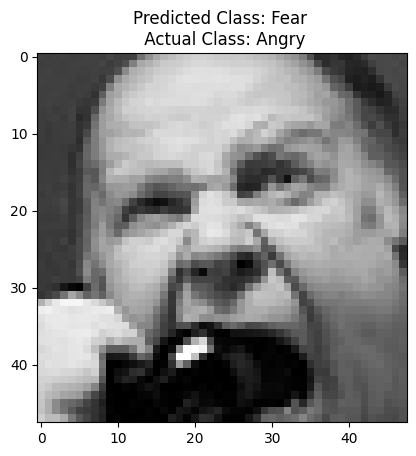

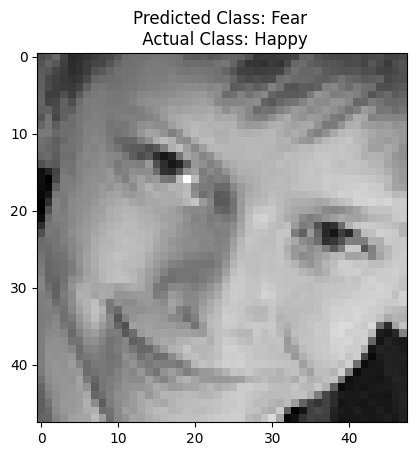

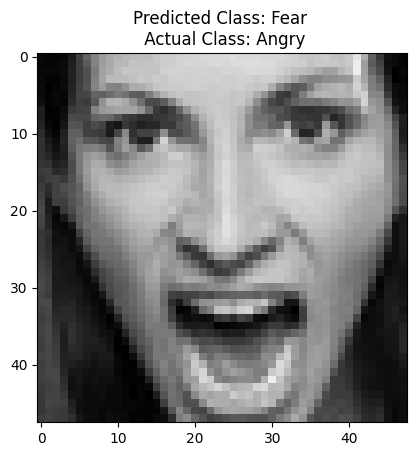

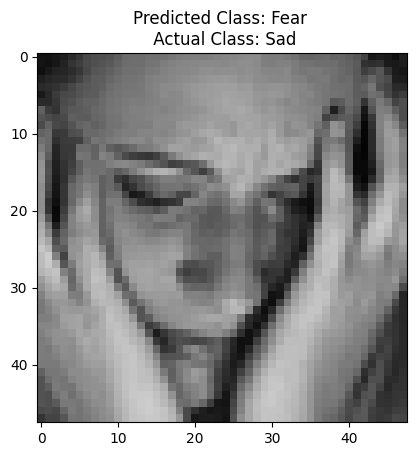

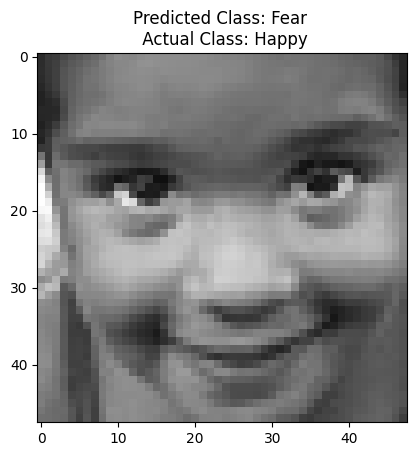

In [ ]:
from random import randint

l = len(filenames)
base_path = TEST_DIR
for i in range(10):  # 10 images

    rnd_number = randint(0,l-1)
    filename,pred_class,actual_class = pred_result.loc[rnd_number]

    img_path = os.path.join(base_path,filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted Class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
    pass

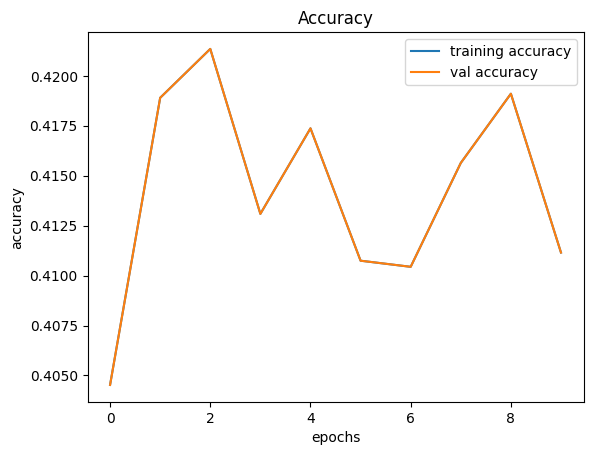

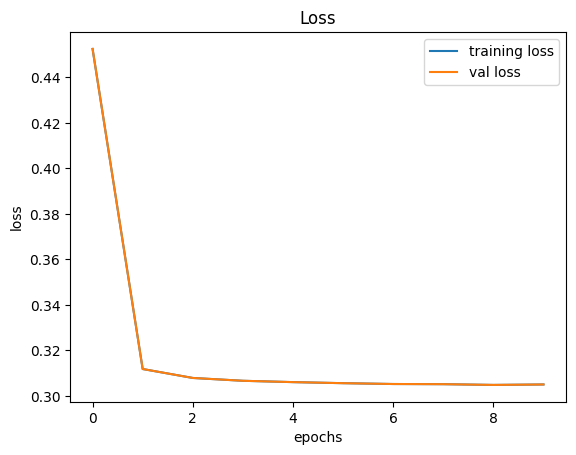

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['accuracy'], label='val accuracy')
plt.title("Accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# For comparison, test a simpler model

In [ ]:
# define the shape of the input images
inp_shape = IMG_SIZE + (3,)
print(inp_shape)

# defining the CNN model with two convolutional layers
n_filters = 32  #vary the number of feature maps
filter_size = (3,3)
model = Sequential()
model.add(Conv2D(n_filters, filter_size, activation='relu', input_shape=inp_shape))
model.add(MaxPool2D((2, 2)))

n_filters = 48    #vary the number of feature maps
filter_size = (3,3)
model.add(Conv2D(n_filters, filter_size, activation='relu'))
model.add(MaxPool2D((2, 2)))
#model.add(Dropout(0.5))  #sometimes may want to drop out a percentage of the neurons

#flatten CNN output down to a vector then output to a two layer BPNN
model.add(Flatten())
model.add(Dense(500, activation='relu'))   #vary # of neurons
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

(48, 48, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 48)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4800)              0         
                                                                 
 dense_2 (Dense)             (None, 500)  

In [ ]:
# define loss and optimizer
model.compile(loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

In [ ]:
# fit the model
history = model.fit(X_train, Y_train, epochs=25, batch_size=128, verbose=2, validation_split=0.25)

Epoch 1/25
58/58 - 4s - loss: 0.2689 - accuracy: 0.5212 - val_loss: 1.0234 - val_accuracy: 0.0648 - 4s/epoch - 72ms/step
Epoch 2/25
58/58 - 1s - loss: 0.2335 - accuracy: 0.5262 - val_loss: 1.1861 - val_accuracy: 0.0228 - 716ms/epoch - 12ms/step
Epoch 3/25
58/58 - 1s - loss: 0.2318 - accuracy: 0.5440 - val_loss: 1.2652 - val_accuracy: 0.0558 - 622ms/epoch - 11ms/step
Epoch 4/25
58/58 - 1s - loss: 0.2310 - accuracy: 0.5379 - val_loss: 1.2033 - val_accuracy: 0.2976 - 569ms/epoch - 10ms/step
Epoch 5/25
58/58 - 1s - loss: 0.2298 - accuracy: 0.5514 - val_loss: 1.3028 - val_accuracy: 8.1533e-04 - 633ms/epoch - 11ms/step
Epoch 6/25
58/58 - 1s - loss: 0.2279 - accuracy: 0.5680 - val_loss: 1.4115 - val_accuracy: 0.0033 - 572ms/epoch - 10ms/step
Epoch 7/25
58/58 - 1s - loss: 0.2278 - accuracy: 0.5648 - val_loss: 1.3868 - val_accuracy: 0.0909 - 822ms/epoch - 14ms/step
Epoch 8/25
58/58 - 1s - loss: 0.2266 - accuracy: 0.5696 - val_loss: 1.3698 - val_accuracy: 0.1158 - 768ms/epoch - 13ms/step
Epoch 9

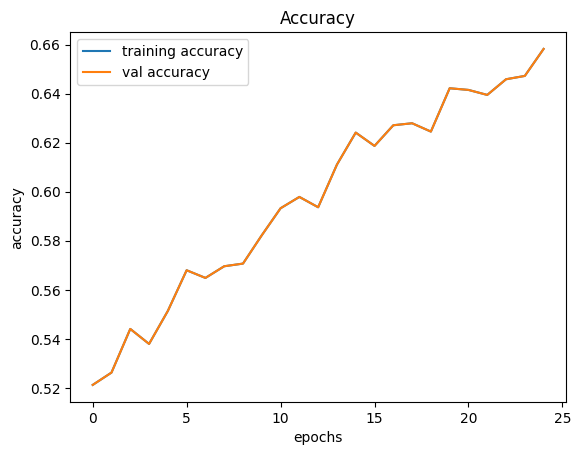

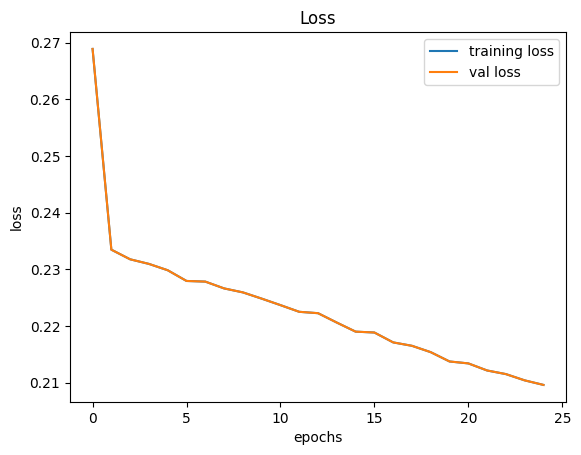

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['accuracy'], label='val accuracy')
plt.title("Accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# Validate on test set
predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]

221/221 [==============================] - 1s 2ms/step


Test Accuracy = 0.17


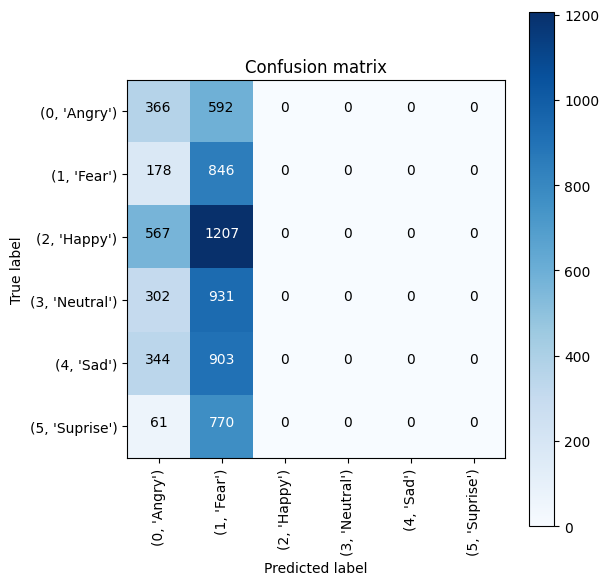

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred)
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)

# Compare with VGG16
Some references: \\
https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/  \\
https://keras.io/api/applications/#usage-examples-for-image-classification-models \\

In [ ]:
#build VGG16 model
from keras.applications.vgg16 import VGG16

base_model = VGG16(
        weights=None,
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
#coonect output to FFNN
NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [ ]:
#chnage epcohs back to 500 when ready to run the whole test
#epochs = 500
epochs = 10
batch_size = 128

history = deep_model(model, X_train, Y_train, epochs, batch_size)

Epoch 1/10
77/77 [==============================] - 11s 104ms/step - loss: 0.4261 - accuracy: 0.4068
Epoch 2/10
77/77 [==============================] - 8s 104ms/step - loss: 0.3099 - accuracy: 0.4205
Epoch 3/10
77/77 [==============================] - 8s 107ms/step - loss: 0.3077 - accuracy: 0.4155
Epoch 4/10
77/77 [==============================] - 8s 106ms/step - loss: 0.3065 - accuracy: 0.4224
Epoch 5/10
77/77 [==============================] - 8s 107ms/step - loss: 0.3059 - accuracy: 0.4178
Epoch 6/10
77/77 [==============================] - 8s 105ms/step - loss: 0.3058 - accuracy: 0.4125
Epoch 7/10
77/77 [==============================] - 8s 106ms/step - loss: 0.3053 - accuracy: 0.4073
Epoch 8/10
77/77 [==============================] - 8s 104ms/step - loss: 0.3048 - accuracy: 0.4240
Epoch 9/10
77/77 [==============================] - 8s 105ms/step - loss: 0.3046 - accuracy: 0.4121
Epoch 10/10
77/77 [==============================] - 8s 103ms/step - loss: 0.3046 - accuracy: 0.411

In [ ]:
# Validate on test set
predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]

221/221 [==============================] - 3s 12ms/step


# Comparewith ResNet50 model

In [ ]:
#build ResNet50 model
from keras.applications.resnet50 import ResNet50

base_model = ResNet50(
        weights=None,
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
#coonect output to FFNN
NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [ ]:
#chnage epcohs back to 500 when ready to run the whole test
#epochs = 500
epochs = 10
batch_size = 128

history = deep_model(model, X_train, Y_train, epochs, batch_size)

Epoch 1/10
77/77 [==============================] - 36s 151ms/step - loss: 0.5586 - accuracy: 0.4039
Epoch 2/10
77/77 [==============================] - 8s 108ms/step - loss: 0.3526 - accuracy: 0.4409
Epoch 3/10
77/77 [==============================] - 8s 108ms/step - loss: 0.3284 - accuracy: 0.4569
Epoch 4/10
77/77 [==============================] - 8s 109ms/step - loss: 0.3131 - accuracy: 0.4946
Epoch 5/10
77/77 [==============================] - 8s 106ms/step - loss: 0.2928 - accuracy: 0.5250
Epoch 6/10
77/77 [==============================] - 8s 107ms/step - loss: 0.2753 - accuracy: 0.5768
Epoch 7/10
77/77 [==============================] - 8s 106ms/step - loss: 0.2451 - accuracy: 0.6370
Epoch 8/10
77/77 [==============================] - 8s 105ms/step - loss: 0.2171 - accuracy: 0.6975
Epoch 9/10
77/77 [==============================] - 8s 106ms/step - loss: 0.1834 - accuracy: 0.7521
Epoch 10/10
77/77 [==============================] - 8s 105ms/step - loss: 0.1442 - accuracy: 0.816

In [ ]:
# Validate on test set
predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]

221/221 [==============================] - 5s 15ms/step


Test Accuracy = 0.22


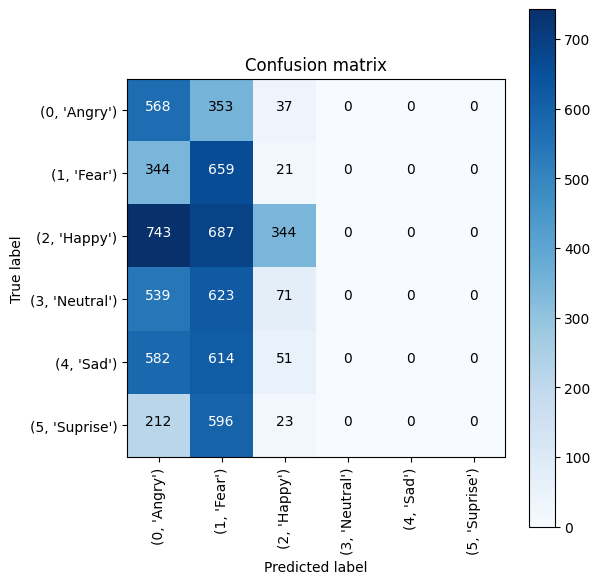

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred)
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)